# 9. Encoder-Decoder for converting dates

_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

## Set up environment

In [2]:
import datetime

import random

from sklearn.model_selection import train_test_split

import keras

import tensorflow as tf

2025-03-22 00:34:14.162426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742600054.278554    7869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742600054.319614    7869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 00:34:14.646565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare data

In [3]:
SAMPLE_SIZE = 10000

In [4]:
def generate_random_dates(start_year, end_year, count):
    random_dates = []
    for _ in range(count):
        year = random.randint(start_year, end_year)
        month = random.randint(1, 12)
        day = random.randint(1, 28)  # To avoid invalid dates
        random_date = datetime.date(year, month, day)
        random_dates.append(random_date)
    return random_dates

In [5]:
dates = generate_random_dates(1900, 2023, SAMPLE_SIZE)
X = [date.strftime("%B %d, %Y") for date in dates]
y = list(map(lambda date: date.isoformat(), dates))

In [6]:
X[:5]

['October 24, 1932',
 'January 23, 1998',
 'September 09, 1917',
 'November 02, 1966',
 'November 16, 1973']

In [7]:
y[:5]

['1932-10-24', '1998-01-23', '1917-09-09', '1966-11-02', '1973-11-16']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(len(X_train))
print(len(X_valid))
print(len(X_test))

8000
1000
1000


## Train model

In [ ]:
START_OF_SEQ = "<"
END_OF_SEQ = ">"

DELIMITER = "-"
COMMA = ","
SPACE = " "

In [30]:
DAYS_MONTHS = [f"{day:02}" for day in range(1, 32)]
MONTHS = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
YEARS = [str(year) for year in range (1900, 2100)]

In [44]:
@tf.function
def split_dash(input_str):
  return tf.strings.split(input_str, sep="-")

In [45]:
text_vec_layer_read = keras.layers.TextVectorization(standardize="strip_punctuation",
    vocabulary=DAYS_MONTHS + MONTHS + YEARS
)

text_vec_layer_iso = keras.layers.TextVectorization(standardize=None, split=split_dash,
    vocabulary=DAYS_MONTHS + YEARS + [START_OF_SEQ, END_OF_SEQ, DELIMITER]
)

In [32]:
VOCAB_SIZE_READ = text_vec_layer_read.vocabulary_size()
print(f"Readable format vocabulary size is {VOCAB_SIZE_READ}")

VOCAB_SIZE_ISO = text_vec_layer_iso.vocabulary_size()
print(f"ISO format vocabulary size is {VOCAB_SIZE_ISO}")

Readable format vocabulary size is 245
ISO format vocabulary size is 236


In [33]:
print(text_vec_layer_read.get_vocabulary())

['', '[UNK]', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984'

In [34]:
print(text_vec_layer_iso.get_vocabulary())

['', '[UNK]', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', 

In [70]:
print(text_vec_layer_read("November 02, 1966"))
print(text_vec_layer_iso(f"{START_OF_SEQ}-1932-10-24-{END_OF_SEQ}"))

tf.Tensor([ 43   3 111], shape=(3,), dtype=int64)
tf.Tensor([233  65  11  25 234], shape=(5,), dtype=int64)


In [73]:
X_train = tf.constant(X_train)
X_valid = tf.constant(X_valid)
X_test = tf.constant(X_test)

X_train_dec = tf.constant([f"{START_OF_SEQ}-{date}" for date in y_train])
X_valid_dec = tf.constant([f"{START_OF_SEQ}-{date}" for date in y_valid])
X_test_dec = tf.constant([f"{START_OF_SEQ}-{date}" for date in y_test])

y_train = text_vec_layer_iso([f"{date}-{END_OF_SEQ}" for date in y_train])
y_valid = text_vec_layer_iso([f"{date}-{END_OF_SEQ}" for date in y_valid])
y_test = text_vec_layer_iso([f"{date}-{END_OF_SEQ}" for date in y_test])

In [84]:
text_vec_layer_read(X_train[:5])

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[ 41,   2,  83],
       [ 42,   8, 153],
       [ 39,  12,  86],
       [ 34,  16, 136],
       [ 42,  16,  57]])>

In [83]:
text_vec_layer_iso(X_test_dec[:5])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[233, 131,   4,   9],
       [233,  41,  10,  16],
       [233,  48,  11,  12],
       [233, 150,   9,  12],
       [233,  35,  10,   5]])>

In [75]:
y_train[:5]

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[ 71,  10,   2, 234],
       [141,  11,   8, 234],
       [ 74,   8,  12, 234],
       [124,   3,  16, 234],
       [ 45,  11,  16, 234]])>

In [76]:
encoder_inputs = keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = keras.layers.Input(shape=[], dtype=tf.string)

In [77]:
EMBED_SIZE_READ = VOCAB_SIZE_READ // 2
EMBED_SIZE_ISO = VOCAB_SIZE_ISO // 2

encoder_input_ids = text_vec_layer_read(encoder_inputs)
decoder_input_ids = text_vec_layer_iso(decoder_inputs)

encoder_embedding_layer = keras.layers.Embedding(
    VOCAB_SIZE_READ, EMBED_SIZE_READ, mask_zero=True
)
decoder_embedding_layer = keras.layers.Embedding(
    VOCAB_SIZE_ISO, EMBED_SIZE_ISO, mask_zero=True
)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [78]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [79]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [80]:
output_layer = tf.keras.layers.Dense(EMBED_SIZE_ISO, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [81]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
model.fit(
    (X_train, X_train_dec),
    y_train,
    epochs=10,
    validation_data=((X_valid, X_valid_dec), y_valid),
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 5.7003e-04 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/10
139/250 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.0000e+00 - loss: nan

KeyboardInterrupt: 

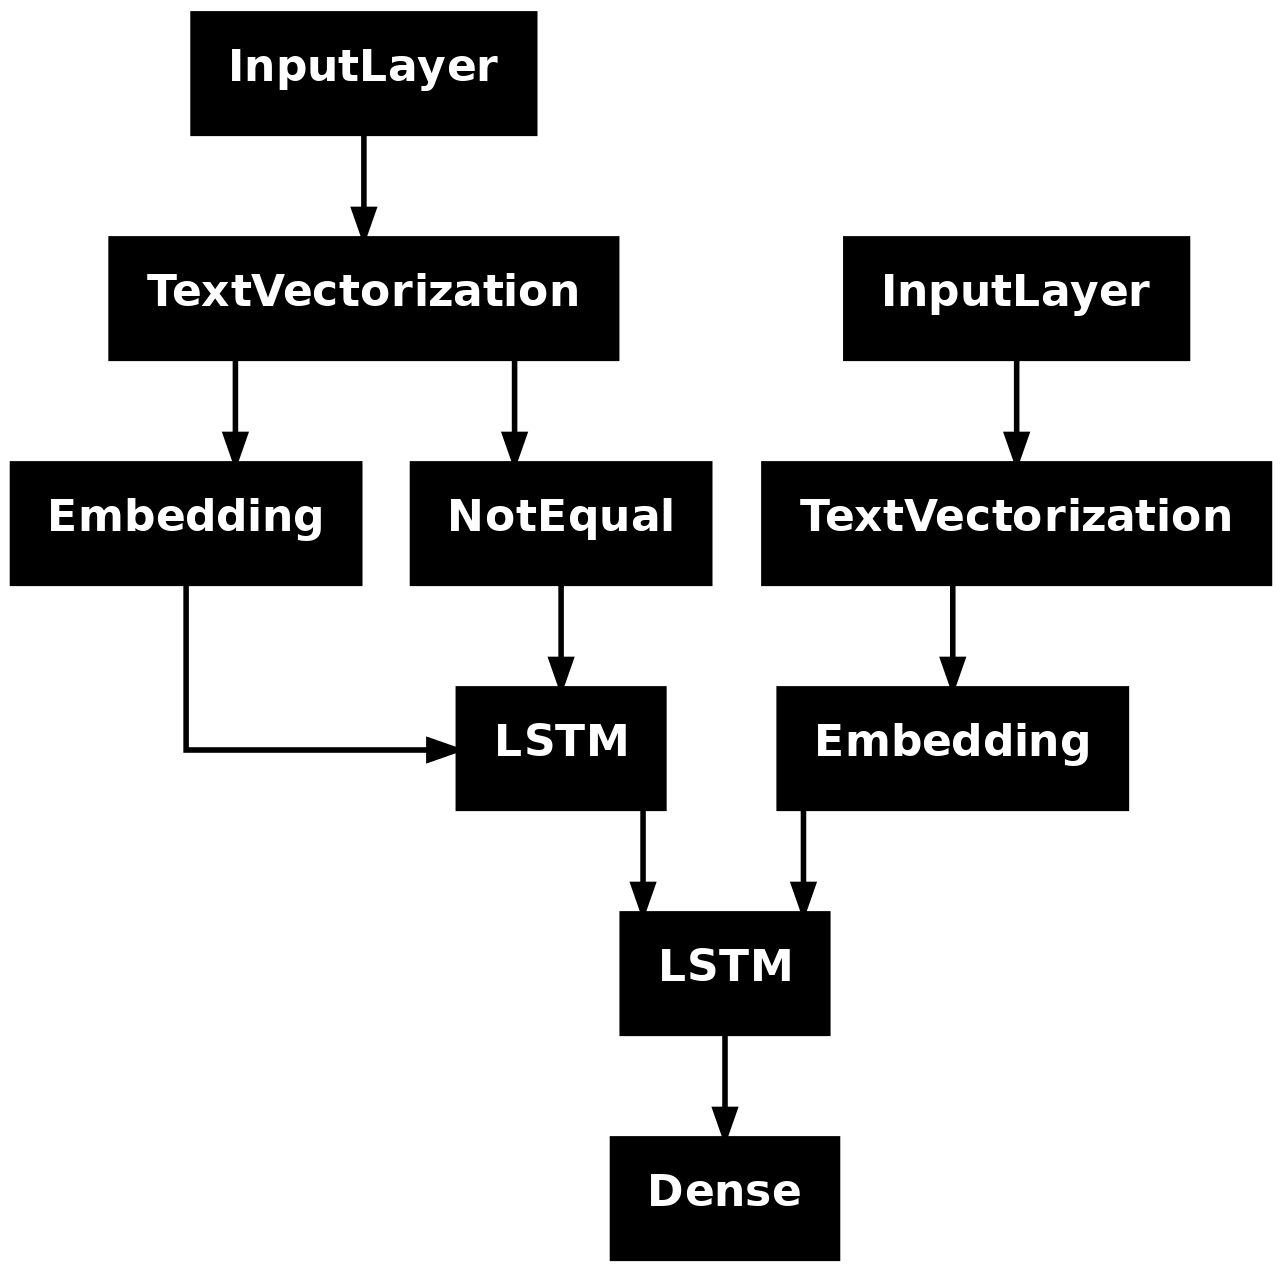

In [ ]:
keras.utils.plot_model(model)